In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

## US Census Data - Case Study

### Executive Summary

US is one of the most diverse nations on this planet. In this work we try to analyze their population census data. The data is extracted from 1994 Census database by UCI and is publicly available. We try tackling the following questions which might be of interest for corporations or population study:

What are the key factors contributing to the high or low income class?

How can we find the people who would be successful investors?

What is the impact of each factor on the high/low income class?

Can we predict if a person had high/low income based on his / her attributes?

### Approach
We summarize the approach for each question as follows:

Feature selection using a random forest classifier to select only relevant features for our analysis. It's important to look at all the features holistically as features are dependent on each other. Through feature selection we find out what are the important features. Charts also explain the same at an individual feature level.

We assume people who have a net capital gain would be good investors. We analyze how this group of people is different from rest of the population. Few features stand-out distinctly and we make note of those. Statistical tests would prove the same but can give more reliability. Our analysis is based on the central measure (mean / mode), variance and plots.

The impact of each feature is measured using Logistic Regression. We use the selected features from the first question's results for building the logistic regression model. As Logistic regression gives very good accuracy comparable to the best accuracy we use it for measuring the impact of each feature. The coefficients are interpreted in terms of odd-ratio of high-income class w.r.t. low-income class.

We try out different supervised learning algorithms. The model is trained on the selected features. Furthermore, we tune the model the give a good cross-validation accuracy. This model is tested on the test data and the results tabulated.

### Importing libraries and data

In [2]:
#Importing libraries
import pandas as pd
import io
import requests
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from scipy.stats import chi2
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.inspection import permutation_importance
from sklearn.ensemble import AdaBoostClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
import time
from IPython.display import HTML, display
from IPython.display import HTML, display
#import tabulate

C:\Users\User\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
url="https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
content =requests.get(url).content
columns = ["age", "workingclass", "fnlwgt", "education", "education-num", "marital-status", "occupation" , "relationship", "race", "sex", "capital-gain", "capital-loss", "hours-per-week", "native-country", "income"] 
adult_df=pd.read_csv(io.StringIO(content.decode('utf-8')), header = None)
adult_df.columns = columns

### Exploratory data analysis & Feature engineering

Dataset information from UCI
UCI has given information about the data and features. We need to understand it thoroughly before we do any analysis.

The data is extracted from the 1994 Census database and is publicly available : US Census data

Following are the attributes and their types:

age: continuous

workclass: categorical

fnlwgt: continuous, represents the number of units the record represents in the population.

education: categorical

education-num: continuous

marital-status: categorical

occupation: categorical

relationship: categorical. Values - Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.

race: categorical

sex: categorical

capital-gain: continuous

capital-loss: continuous

hours-per-week: continuous, number of work the person has worked for in a week

native-country: categorical

income: categorical, class (not attribute) <=50K and >50K

### High-level overview

In [6]:
#Attribute statistics 
adult_df_shape = adult_df.shape
adult_df_shape

(32561, 15)

### Handling Null / Missing Values

In [7]:
#removing end blank spaces
df_obj = adult_df.select_dtypes(['object'])
adult_df[df_obj.columns] = df_obj.apply(lambda x: x.str.strip())

There are no null values. We check for missing values in each of the variable

In [8]:
#Check for missing values in all the columns
adult_df.isin(["?"]).sum()

age                  0
workingclass      1836
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
income               0
dtype: int64

In [9]:
#Dropping missing values
adult_df = adult_df.loc[adult_df["workingclass"] !="?"]
adult_df = adult_df.loc[adult_df["occupation"] !="?"]
adult_df = adult_df.loc[adult_df["native-country"] !="?"]

In [10]:
print("Lost rows = "+str(round(1 - (adult_df.shape[0]/32561),4)*100)+"%")

Lost rows = 7.37%


### Describe variables

#### Continuous / Integer variables

In [11]:
#Describe each continuous variable
adult_df.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,30162.000000,3.016200e+04,30162.000000,30162.000000,30162.000000,30162.000000
mean,38.437902,1.897938e+05,10.121312,1092.007858,88.372489,40.931238
std,13.134665,1.056530e+05,2.549995,7406.346497,404.298370,11.979984
min,17.000000,1.376900e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.176272e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.784250e+05,10.000000,0.000000,0.000000,40.000000
75%,47.000000,2.376285e+05,13.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


We check for total sum of "fnlwgt" to see if it makes sense

Observations:

1. Age of all the individauls is >17
2. age, education-num and hours-per-week seem approx. normal distributions. We can further check the distributions to confirm
3. More than 75% of the data in capital-gain and capital-loss column is 0 as we see with 3rd Quartile (75%) = 0
4. fnlwgt can be dropped as we're unclear of it's usage - sum of fnlwgt is greater than total US population


#### Categorical variables

In [12]:
#Describe each categorical variable
adult_df.describe(include = ["O"])

,workingclass,education,marital-status,occupation,relationship,race,sex,native-country,income
count,30162,30162,30162,30162,30162,30162,30162,30162,30162
unique,7,16,7,14,6,5,2,41,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,22286,9840,14065,4038,12463,25933,20380,27504,22654


Observation:
Most of the data consists of people of workingclass = Private, Race = White, Native country = US, income <=50K

### Analysing variables and encoding
We try to check distributions of continuous variables and counts of categorical variables. Encoding and dropping of variables is done based on logical sense. However, we restrict this activity to be as minimal as possible in order to not lose out on information

#### Continuous variables
#### Age, education-num and hours-per-week

C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level 

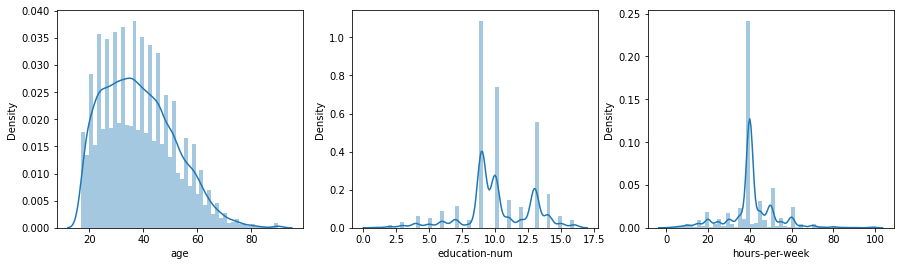

In [13]:
fig, ax = plt.subplots(1,3, figsize = (15,4));
sns.distplot(adult_df["age"], ax = ax[0]);
sns.distplot(adult_df["education-num"], ax = ax[1]);
sns.distplot(adult_df["hours-per-week"], ax = ax[2]);

Observations:

1. Age is right-skewed distribution since we have the dataset of adults only
2. Education-num is not continuous and has integer values only, we can further check this
3. Hours-per-week has a huge spike at 40 which is normal working hours

##### Capital-loss and capital-gain

C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


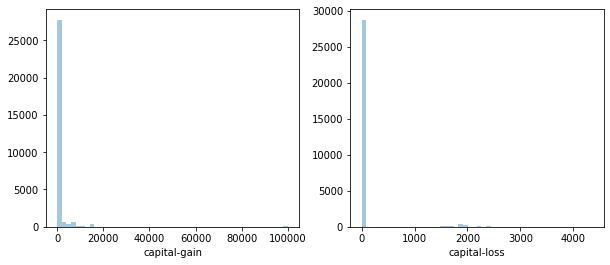

In [14]:
fig, ax = plt.subplots(1,2, figsize = (10,4));
sns.distplot(adult_df["capital-gain"], ax = ax[0], kde = False);
sns.distplot(adult_df["capital-loss"], ax = ax[1], kde = False);

Most values in capital-gain and capital-loss are 0

In [15]:
print("Percentage of 0 values in capital-gain = "+str(round(np.mean(adult_df["capital-gain"]==0),2)*100)+"%")


Percentage of 0 values in capital-gain = 92.0%


In [16]:
print("Percentage of 0 values in capital-gain = "+str(round(np.mean(adult_df["capital-loss"]==0),2)*100)+"%")

Percentage of 0 values in capital-gain = 95.0%


Percentage of 0 values in capital-gain = 95.0%
As both the variables are related we encode them as one - capital-net_>0

1. (capital-gain) - (capital-loss) > 0 then 1
2. (capital-gain) - (capital-loss) <=0 then 0

In [17]:
adult_df["capital-net_>0"] = ((adult_df['capital-gain']- adult_df["capital-loss"]) > 0)*1

#### Categorical variables
##### Education

Education-num and education are expected to be highly correlated. We check this using a contingency table.

In [18]:
cont_table = pd.crosstab(adult_df["education"],adult_df["education-num"], margins = False)
cont_table

education-num,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
education,,,,,,,,,,,,,,,,
10th,0,0,0,0,0,820,0,0,0,0,0,0,0,0,0,0
11th,0,0,0,0,0,0,1048,0,0,0,0,0,0,0,0,0
12th,0,0,0,0,0,0,0,377,0,0,0,0,0,0,0,0
1st-4th,0,151,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5th-6th,0,0,288,0,0,0,0,0,0,0,0,0,0,0,0,0
7th-8th,0,0,0,557,0,0,0,0,0,0,0,0,0,0,0,0
9th,0,0,0,0,455,0,0,0,0,0,0,0,0,0,0,0
Assoc-acdm,0,0,0,0,0,0,0,0,0,0,0,1008,0,0,0,0
Assoc-voc,0,0,0,0,0,0,0,0,0,0,1307,0,0,0,0,0


##### Workingclass
Check for % values of each category

In [19]:
round(adult_df["workingclass"].value_counts(normalize = True)*100,2)

Private             73.89
Self-emp-not-inc     8.29
Local-gov            6.85
State-gov            4.24
Self-emp-inc         3.56
Federal-gov          3.13
Without-pay          0.05
Name: workingclass, dtype: float64

We can group workingclass types into fewer categories are meaningful categories

1. Govt = Federal-gov, Local-gov and State-gov
2. Self-emp = Self-emp-inc, Self-emp-not-inc
3. No-work-inc = Without pay, Never worked

In [20]:
##Encoding different types of govt jobs to a single value
adult_df.loc[((adult_df["workingclass"] == "Federal-gov")| (adult_df["workingclass"] == "Local-gov")  |(adult_df["workingclass"] == "State-gov")), "workingclass"] = "Govt"
adult_df.loc[((adult_df["workingclass"] == "Self-emp-inc")| (adult_df["workingclass"] == "Self-emp-not-inc")), "workingclass"] = "Self-emp"
adult_df.loc[((adult_df["workingclass"] == "Without-pay")| (adult_df["workingclass"] == "Never-worked")), "workingclass"]  = "No-work-inc"

#### Race
Check for % values of each category

In [21]:
round(adult_df["race"].value_counts(normalize = True)*100,2)

White                 85.98
Black                  9.34
Asian-Pac-Islander     2.97
Amer-Indian-Eskimo     0.95
Other                  0.77
Name: race, dtype: float64

We hardly have any data for the last three categories, we can encode them into "Other" category

In [22]:
adult_df.loc[((adult_df["race"] == "Amer-Indian-Eskimo") | (adult_df["race"] == "Asian-Pac-Islander")),  "race"] = "Other"


#### Marital-status
Check for % values of each category

In [23]:
round(adult_df["marital-status"].value_counts(normalize = True)*100,2)

Married-civ-spouse       46.63
Never-married            32.25
Divorced                 13.97
Separated                 3.11
Widowed                   2.74
Married-spouse-absent     1.23
Married-AF-spouse         0.07
Name: marital-status, dtype: float64

We can encode these into 3 categories

1. Married = Married-civ-spouse, Married-spouse-absent, Married-AF-spouse
2. Not-married (Separated, Divorced and Widowed)
3. Never-Married

#### Occupation
Check for % values of each category

Each occupation is unique. Some occupations have very low counts (last 3) and do not add much value to the data. We encode them by creating "Other" category

#### Relationship
Check for % values of each category

In [24]:
round(adult_df["relationship"].value_counts(normalize = True)*100,2)

Husband           41.32
Not-in-family     25.62
Own-child         14.81
Unmarried         10.65
Wife               4.66
Other-relative     2.95
Name: relationship, dtype: float64

Since we already have marital-status, relationship variable is redundant as husband, wife values will always be married. Therefore, we can drop it

#### Native-country
Check for % values of US and Mexico

In [25]:
cntry_counts = adult_df["native-country"].value_counts()
print("Total number of countries = "+ str(len(cntry_counts)))
print(round(cntry_counts[0:2]/np.sum(cntry_counts),2)*100)

Total number of countries = 41
United-States    91.0
Mexico            2.0
Name: native-country, dtype: float64


In [26]:
adult_df.loc[((adult_df["native-country"] != "United-States") & (adult_df["native-country"] != "Mexico")),"native-country"] = "Other"

#### Class - Distribution

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


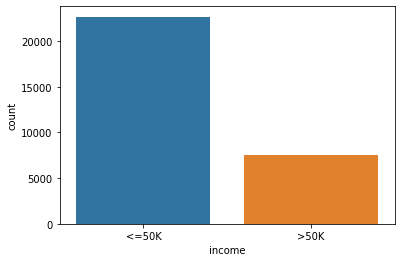

In [27]:
sns.countplot(adult_df["income"]);

We have 75% of the population below 50K income and 25% above 50K

#### Dropping variables
In this section, we drop variables which have been identified as irrelevant or redundant due because of other variables

##### capital-gain and capital-loss - as we have capital-net_>0

In [28]:
adult_df.drop(["capital-gain", "capital-loss"], axis = 1, inplace =True)

##### education - as we have education-num

In [29]:
adult_df.drop("education", axis = 1, inplace = True)

##### fnlwgt - unsure about its interpretation

In [30]:
adult_df.drop("fnlwgt", axis = 1, inplace = True)

##### relationship - as this information is already conveyed by marital status

In [31]:
adult_df.drop("relationship", axis = 1, inplace = True)

#### Dummy encoding of categorical features

We encode categorical variables using one-hot encoding so make the data usable for a classifier

In [32]:
adult_df_new = pd.get_dummies(adult_df)

In [33]:
#One-hot encoding, we drop one variable which is redundant to avoid issues of multicollinearity 
#adult_df_new.drop("workingclass_No-work-inc", axis = 1, inplace = True)
#adult_df_new.drop("marital-status_Not-Married", axis = 1, inplace = True)
#adult_df_new.drop("occupation_Other", axis = 1, inplace = True)
adult_df_new.drop("race_Other", axis = 1, inplace = True)
adult_df_new.drop("sex_Female", axis = 1, inplace = True)
adult_df_new.drop("native-country_Other", axis = 1, inplace = True)
adult_df_new.drop("income_<=50K", axis = 1, inplace = True)

#### Correlation
In this section, we check for correlation between the features

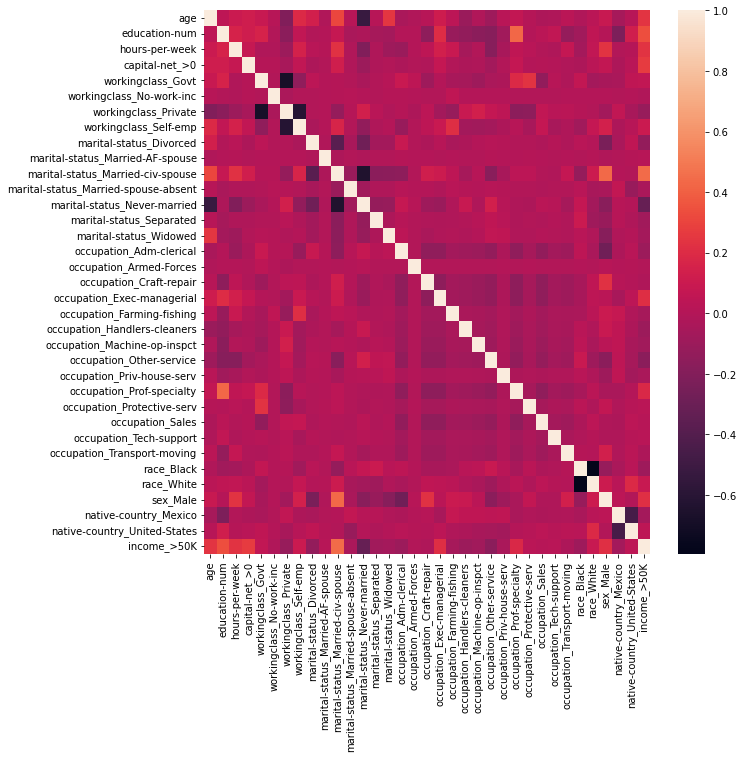

In [34]:
plt.figure(figsize = (10,10));
sns.heatmap(adult_df_new.corr());

#### Observations:

1. Age has a strong negative correlation with marital-status
2. Native-country and race have a high correlation for specific values
3. Surprisingly native-country also has a correlation with education-num
4. Many of the features have good correlation with the class income > 50k
5. Therefore, we need to select features so as to not overestimate or underestimate a feature's importance

#### Feature Selection
In this section, we try to find out important features for model building. This will be used for all the analysis

Implementation of random forest classifier and check feature importance
We compare the performance of the classifier using the feature and comparing it with its randomly permuted copies

In [35]:
rf = RandomForestClassifier()
rf.fit(adult_df_new.loc[:, adult_df_new.columns != "income_>50K"], adult_df_new["income_>50K"]);
result = permutation_importance(rf, adult_df_new.loc[:, adult_df_new.columns != "income_>50K"], adult_df_new["income_>50K"], n_repeats=5)
sorted_idx = result.importances_mean.argsort()

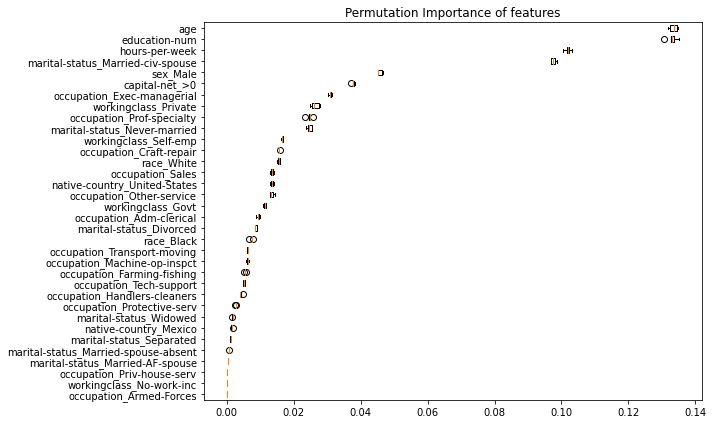

In [36]:
fig, ax = plt.subplots(figsize = (10,6))
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=adult_df_new.loc[:, adult_df_new.columns != "income_>50K"].columns[sorted_idx])
ax.set_title("Permutation Importance of features")
fig.tight_layout()
plt.show()

#### Observation:

We categorize the features based on importance for simplicity:

1. Very important features: age, education_num, marital_status, hours_per_week
2. Other important features: sex, capital_net>0, Occupation (top ones) , working-class, race
    
We drop the not so important features, if it's a categorical feature then it is automatically encoded in "Other" category

In [37]:
features = adult_df_new.loc[:, adult_df_new.columns != "income_>50K"].columns

features_selected = list(features[result.importances_mean > 0.01])
features_vimp = list(features[result.importances_mean > 0.05])
features_imp = list(features[(result.importances_mean <= 0.05) & (result.importances_mean > 0.01)])

#We select only the important features
adult_df_new = adult_df_new.loc[:,features_selected+["income_>50K"]]

### Inferential Analysis

#### Factors impacting the high/low income class
In this section, we check for factors affecting the high/low income class in terms of the features we have selected

#### Very important features

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Hours-per-week quantiles by income class')

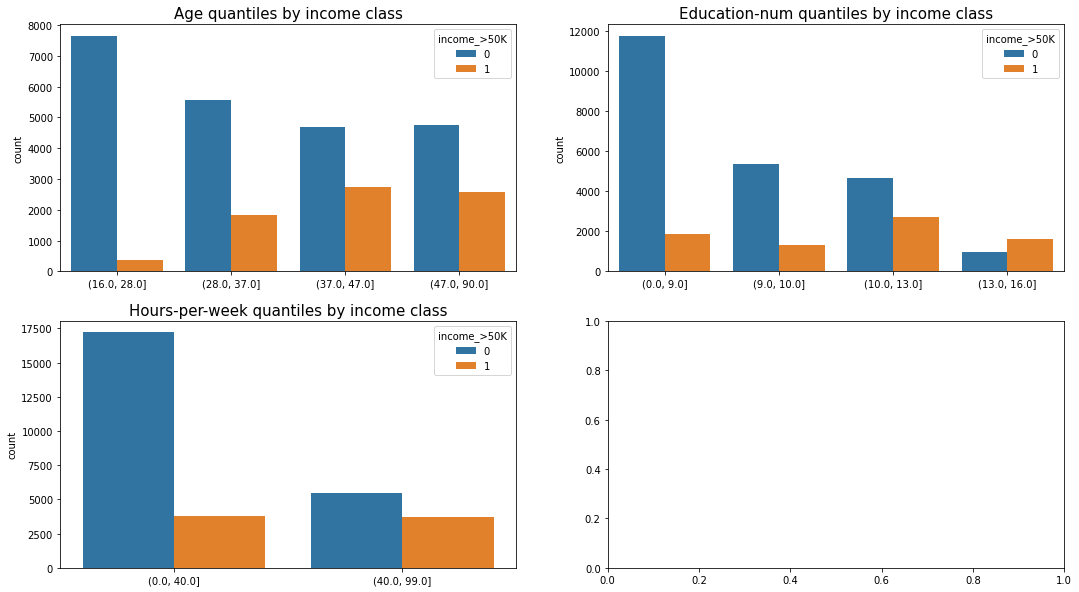

In [38]:
fig, ax = plt.subplots(2,2, figsize=(18,10))
quantiles = pd.qcut(adult_df_new['age'], q=4, precision = 0)
s0 = sns.countplot(quantiles, hue = adult_df_new["income_>50K"], ax = ax[0][0])
s0.set_xlabel(None)
s0.set_title("Age quantiles by income class",fontsize=15)


quantiles = pd.qcut(adult_df_new['education-num'], q=4, precision = 0)
s1 = sns.countplot(quantiles, hue = adult_df_new["income_>50K"], ax = ax[0][1])
s1.set_xlabel(None)
s1.set_title("Education-num quantiles by income class",fontsize=15)


quantiles = pd.qcut(adult_df_new['hours-per-week'], q= 2, precision = 0)
s2 = sns.countplot(quantiles, hue = adult_df_new["income_>50K"], ax = ax[1][0])
s2.set_xlabel(None)
s2.set_title("Hours-per-week quantiles by income class",fontsize=15)


#s3 = sns.countplot(adult_df_new['marital-status_Married'], hue = adult_df_new["income_>50K"], ax = ax[1][1])
#s3.set_xlabel(None)
#s3.set_xticklabels(["Never / Not Married", "Married"])
#s3.set_title("Marital-status by income class",fontsize=15);

#### Inference:

Lower ages have a low proportion of high income class, the proportion of high income increases with age and decreases a bit later
The proportion of high-income class increases with education number
Proportion is high income is higher for people who work more hours
Married people have a higher proportion of high-income class

#### Other important features

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-p

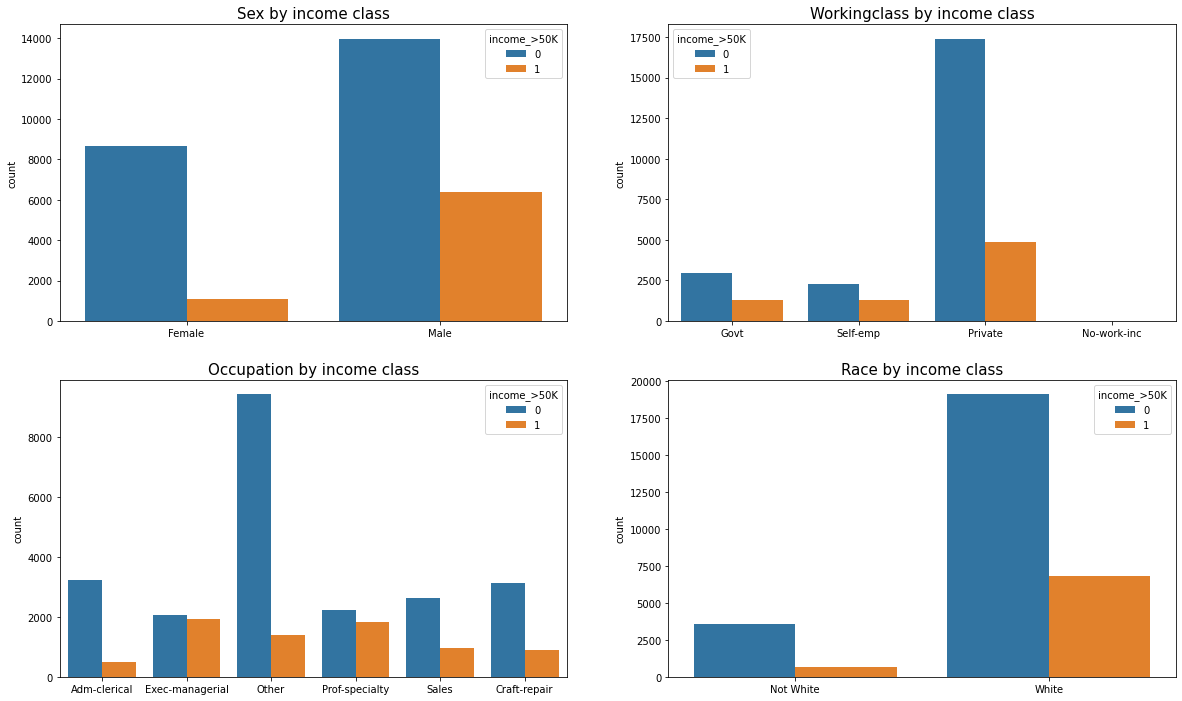

In [39]:
# Removing irrelevant features amongst occupation
adult_df.loc[~((adult_df["occupation"] == "Adm-clerical") | (adult_df["occupation"] == "Craft-repair") | 
                      (adult_df["occupation"] == "Exec-managerial") | (adult_df["occupation"] == "Prof-specialty")|
                      (adult_df["occupation"] == "Sales")),"occupation"] = "Other"
fig, ax = plt.subplots(2,2, figsize=(20,12))
s0 = sns.countplot(adult_df_new["sex_Male"], hue = adult_df_new["income_>50K"], ax = ax[0][0])
s0.set_xlabel(None)
s0.set_xticklabels(["Female", "Male"])
s0.set_title("Sex by income class",fontsize=15)


s1 = sns.countplot(adult_df['workingclass'], hue = adult_df_new["income_>50K"], ax = ax[0][1])
s1.set_xlabel(None)
s1.set_title("Workingclass by income class",fontsize=15)


s2 = sns.countplot(adult_df["occupation"],  hue = adult_df_new["income_>50K"], ax = ax[1][0])
s2.set_xlabel(None)
s2.set_title("Occupation by income class",fontsize=15)


s3 = sns.countplot(adult_df_new["race_White"], hue = adult_df_new["income_>50K"], ax = ax[1][1])
s3.set_xlabel(None)
s3.set_xticklabels(["Not White", "White"])
s3.set_title("Race by income class",fontsize=15);

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


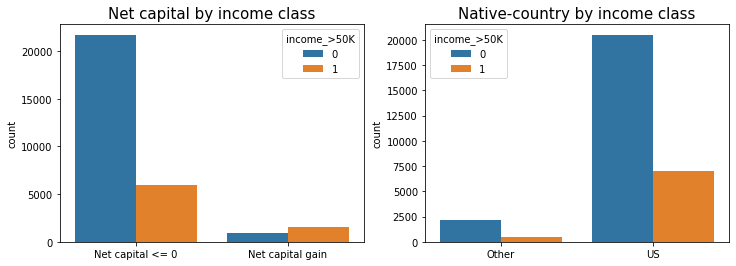

In [40]:
fig, ax = plt.subplots(1,2, figsize = (12,4));

s0 = sns.countplot(adult_df_new["capital-net_>0"], hue = adult_df_new["income_>50K"], ax = ax[0])
s0.set_xlabel(None)
s0.set_xticklabels(["Net capital <= 0", "Net capital gain"])
s0.set_title("Net capital by income class",fontsize=15)

s1 = sns.countplot(adult_df_new["native-country_United-States"], hue = adult_df_new["income_>50K"], ax = ax[1])
s1.set_xlabel(None)
s1.set_xticklabels(["Other", "US"])
s1.set_title("Native-country by income class",fontsize=15);

#### Inference:

1. Males have a higher proportion of the high-income class
2. Self-emp people have a very high proportion of high-income class while Govt and Private have high proportions while other sections have low proportions of high-income class
3. Prof-speciality, exec-managerial have a higher proportion of the high-income class
4. Whites have a bit higher proportion of the high-income class
5. Net capital gain has a higher proportion of high-income class people
6. Native country US have a bit higher proportion of the high-income class

### Finding out the potential investors
We try to find out the profiles of potential investors who have had a positive capital-gain

Steps:

1. Divide the population into 2 groups: positive net-capital and others
2. Compare the features of both the groups to see which features are distinctively different

In [41]:
#We divide the population into 2, capital_gp = population with net-capital gain and capita_op = other population
capital_gp = adult_df_new.loc[adult_df_new["capital-net_>0"] > 0,]
capital_op = adult_df_new.loc[adult_df_new["capital-net_>0"] == 0,]

In [42]:
capital_gp.describe()

,age,education-num,hours-per-week,capital-net_>0,workingclass_Govt,workingclass_Private,workingclass_Self-emp,marital-status_Married-civ-spouse,marital-status_Never-married,occupation_Craft-repair,occupation_Exec-managerial,occupation_Other-service,occupation_Prof-specialty,occupation_Sales,race_White,sex_Male,native-country_United-States,income_>50K
count,2538.000000,2538.000000,2538.000000,2538.0,2538.000000,2538.000000,2538.000000,2538.000000,2538.000000,2538.000000,2538.000000,2538.000000,2538.00000,2538.000000,2538.000000,2538.000000,2538.000000,2538.000000
mean,43.506698,11.105595,44.009062,1.0,0.151300,0.671001,0.176911,0.673365,0.167849,0.120567,0.212372,0.038613,0.21316,0.124507,0.892435,0.778960,0.929472,0.628448
std,12.715070,2.624413,11.672086,0.0,0.358412,0.469942,0.381669,0.469075,0.373806,0.325688,0.409067,0.192709,0.40962,0.330225,0.309891,0.415029,0.256085,0.483315
min,17.000000,1.000000,2.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,35.000000,9.000000,40.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000,1.000000,1.000000,0.000000
50%,42.000000,11.000000,40.000000,1.0,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000,1.000000,1.000000,1.000000
75%,51.000000,13.000000,50.000000,1.0,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000,1.000000,1.000000,1.000000
max,90.000000,16.000000,99.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000


In [43]:
capital_op.describe()

,age,education-num,hours-per-week,capital-net_>0,workingclass_Govt,workingclass_Private,workingclass_Self-emp,marital-status_Married-civ-spouse,marital-status_Never-married,occupation_Craft-repair,occupation_Exec-managerial,occupation_Other-service,occupation_Prof-specialty,occupation_Sales,race_White,sex_Male,native-country_United-States,income_>50K
count,27624.000000,27624.000000,27624.000000,27624.0,27624.000000,27624.000000,27624.000000,27624.000000,27624.000000,27624.000000,27624.000000,27624.000000,27624.000000,27624.000000,27624.000000,27624.000000,27624.000000,27624.000000
mean,37.972198,10.030879,40.648458,0.0,0.141363,0.745113,0.113090,0.447292,0.336664,0.134810,0.125000,0.112728,0.126593,0.118303,0.856791,0.666196,0.910259,0.214053
std,13.074567,2.523916,11.968447,0.0,0.348401,0.435806,0.316709,0.497223,0.472577,0.341527,0.330725,0.316266,0.332522,0.322972,0.350292,0.471579,0.285815,0.410171
min,17.000000,1.000000,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27.000000,9.000000,40.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
50%,37.000000,10.000000,40.000000,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
75%,47.000000,12.000000,45.000000,0.0,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
max,90.000000,16.000000,99.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Observation:
We observe there is a lot of variation between the two groups based on the following columns:

1. Marital status Married
2. Occupation - Exec managerial
3. Occupation - Prof speciality
4. Income > 50k

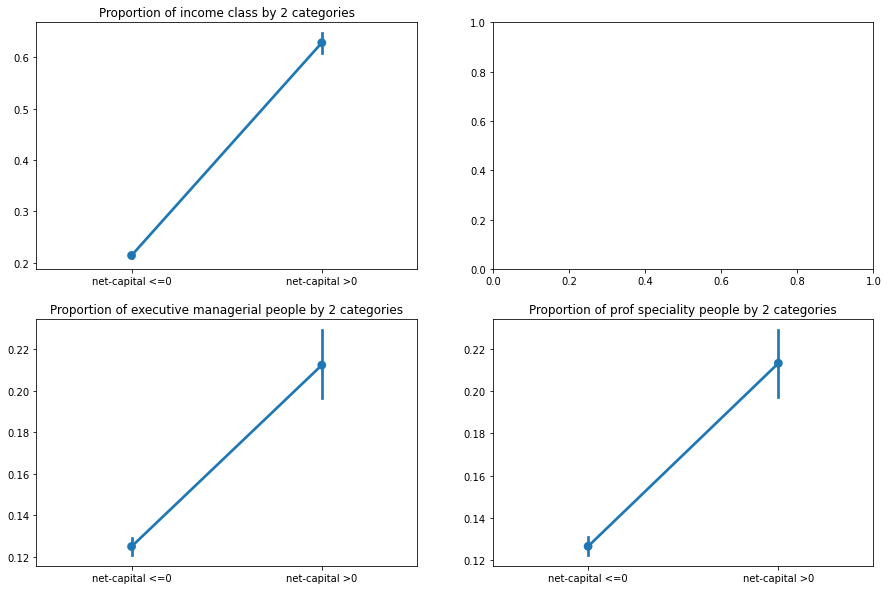

In [52]:
fig, ax = plt.subplots(2,2, figsize=(15,10))
s0 = sns.pointplot(x = "capital-net_>0", y = "income_>50K",  data = adult_df_new, ax = ax[0][0])
s0.set_xticklabels(["net-capital <=0", "net-capital >0"])
s0.set_xlabel(None)
s0.set_ylabel(None)
s0.set_title("Proportion of income class by 2 categories",fontsize=12)



s2 = sns.pointplot(x = "capital-net_>0", y = "occupation_Exec-managerial",  data = adult_df_new, ax = ax[1][0])
s2.set_xticklabels(["net-capital <=0", "net-capital >0"])
s2.set_xlabel(None)
s2.set_ylabel(None)
s2.set_title("Proportion of executive managerial people by 2 categories",fontsize=12)

s3 = sns.pointplot(x = "capital-net_>0", y = "occupation_Prof-specialty",  data = adult_df_new, ax = ax[1][1])
s3.set_xticklabels(["net-capital <=0", "net-capital >0"])
s3.set_xlabel(None)
s3.set_ylabel(None)
s3.set_title("Proportion of prof speciality people by 2 categories",fontsize=12);


#### Inference:

We summarise the findings w.r.t. estimated successful investors group (i.e. people with postive net-capital)

1. 63% this group belongs to high income-class compared to only 21% of the other population
2. 68% of the group is married, compared to 45% of the other population
3. 43% of the group work as executive managers or in specialty professions compared to 25% of the other population

### Impact of each feature on high/low income class
In this section we try to quantify the impact of each feature in determining high/low income class. Steps

1. Fit a logistic regression model w.r.t. high income class
2. Interpret coefficients of logistic regression in terms of odds-ratio of high income class w.r.t. low income class

In [53]:
X = adult_df_new.loc[:, features_selected] 
y = adult_df_new["income_>50K" ]

lr = LogisticRegression(penalty = "l2", C=1, max_iter = 1000)
lr.fit(X, y);

coeffs = lr.coef_

impact_features = pd.Series(index = list(X.columns),data = coeffs[0])

age_impact_10 = np.exp(impact_features["age"]*10)
edu_impact = np.exp(impact_features["education-num"])
hours_impact = np.exp(impact_features["hours-per-week"]*5)
#ms_impact = np.exp(impact_features["marital-status_Married"])
net_capital_impact = np.exp(impact_features["capital-net_>0"])
sex_impact = np.exp(impact_features["sex_Male"])
race_impact = np.exp(impact_features["race_White"])

#### Inference:

1. Age – Increase in age by 10 years increases the odds of high-income-class by 1.3 times
2. Education – Unit increase in education years increases the odds of the high-income class by 1.36 times
3. Hours per week –Increase in work hours per week by 5 years increases the odds of high income-class by 1.15 times
4. Marital status – Married people have 7.5 times odds of high-income class
5. Net capital – If net-capital is more than 0 it increases odds of the high-income class by 4.9 times
6. Sex – Men make odds of high-income class increase by 1.36 times as compared to women
7. Race – Whites increase the odds of high-income class increase by 1.17 times as compared to other races

### Predictive Modeling
In this section, we build models so as to predict whether a person belongs to high/low income class based on his/her attributes.


Steps:

1. Fit training data
2. Tune hyperparameters to get a good cross-validation accuracy
3. Compare different models in terms of accuracy and run-time
4. Test the best models on the test set

#### Building the model

##### Null model

Baseline model: This serves as a comparison for other models. We predict the larger class every time

In [ ]:
summary = pd.DataFrame(columns = ["model", "accuracy", "time(s)"])

score_0 = round(np.mean(y==0),2)

summary = summary.append({"model":"Null", "accuracy": score_0, "time(s)":0}, ignore_index=  True)

#### Decision Tree

1. maximum depth = 10
2. split criterion = gini coefficient
3. complexity parameter = 0

In [ ]:
kfoldCV = StratifiedKFold(n_splits=5, shuffle = True, random_state=0)
tick = time.time()
dt = DecisionTreeClassifier(max_depth = 10, random_state = 24)
dt_scores = cross_val_score(dt, X, y, cv = kfoldCV)
tock = time.time()
summary = summary.append({"model":"Decison Tree", "accuracy": np.round(np.mean(dt_scores),2), "time(s)":round((tock - tick),2)}, ignore_index=  True)

#### Random Forest

1. maximum depth = 10
2. total estimators = 100
3. split criterion = gini coefficient
4. maximum features (in each tree) = sqrt(number of features)

In [ ]:
tick = time.time()
rf = RandomForestClassifier(n_estimators = 100, max_depth = 10, random_state = 24)
rf_scores = cross_val_score(rf, X, y, cv = kfoldCV)
tock = time.time()
summary = summary.append({"model":"Random Forest", "accuracy": np.round(np.mean(rf_scores),2), "time(s)":round((tock - tick),2)}, ignore_index=  True)

#### AdaBoost

1. base estimator = decision stump (decision tree max depth = 1)
2. estimators = 50
3. learning rate = 0.1

In [ ]:
tick = time.time()
ada = AdaBoostClassifier(learning_rate = 0.1, random_state = 24)
ada_scores = cross_val_score(ada, X, y, cv = kfoldCV)
tock = time.time()
summary = summary.append({"model":"AdaBoost", "accuracy": np.round(np.mean(ada_scores),2), "time(s)": round((tock - tick),2)}, ignore_index=  True)

#### XGBoost
1. booster = gradient boosted tree
2. learning rate = 0.1
3. maximum depth = 5
4. regularization = lambda (l2), weight = 1

In [ ]:
tick = time.time()
xgb = XGBClassifier(max_depth = 5, learning_rate=0.1)
xgb_scores = cross_val_score(xgb, X, y, cv = 5)
tock = time.time()

summary = summary.append({"model":"XGBoost", "accuracy": np.round(np.mean(xgb_scores),2), "time(s)": round((tock - tick),2)}, ignore_index=  True)

#### Classifiers which require feature scaling

In [ ]:
scaler = MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

#### Logistic Regression
1. regularization = l2
2. regularization weight (C) = 1

In [ ]:
tick = time.time()
lr = LogisticRegression(penalty = "l2", max_iter=1000, solver = "liblinear")
lr_scores = cross_val_score(lr, X_scaled, y, cv = 5)
tock = time.time()
summary = summary.append({"model":"Logistic Regression", "accuracy": np.round(np.mean(lr_scores),2), "time(s)": round((tock - tick),2)}, ignore_index=  True)

#### SVM
1. kernel = rbf
C = 1
2. gamma = 1/(number of features)

In [ ]:
tick = time.time()
svm = SVC(kernel = "rbf", C = 1, gamma = "auto")
svm_scores = cross_val_score(svm, X_scaled, y, cv = 5)
tock = time.time()
summary = summary.append({"model":"SVM", "accuracy": np.round(np.mean(lr_scores),2), "time(s)": round((tock - tick),2)}, ignore_index=  True)

### Testing on new data
#### Importing the test data

In [75]:
url="https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test"
content =requests.get(url).content
columns = ["age", "workingclass", "fnlwgt", "education", "education-num", "marital-status", "occupation" , "relationship", "race", "sex", "capital-gain", "capital-loss", "hours-per-week", "native-country", "income"] 
adult_test=pd.read_csv(io.StringIO(content.decode('utf-8')), skiprows=1, header = None)

In [76]:
test_data_shape = adult_test.shape

In [77]:
adult_test.columns = columns
#removing end blank spaces
df_obj = adult_test.select_dtypes(['object'])
adult_test[df_obj.columns] = df_obj.apply(lambda x: x.str.strip())
adult_test.loc[adult_test["income"] == ">50K.", "income"] = ">50K"
adult_test.loc[adult_test["income"] == "<=50K.", "income"] = "<=50K"

#### Handling null / missing values

In [78]:
adult_test.dropna(inplace = True)
adult_test = adult_test.loc[adult_test["workingclass"] !="?"]
adult_test = adult_test.loc[adult_test["occupation"] !="?"]
adult_test = adult_test.loc[adult_test["native-country"] !="?"]

#### Encoding features like the training data

In [79]:
adult_test["capital-net_>0"] = ((adult_test['capital-gain']- adult_test["capital-loss"]) > 0)*1

adult_test.loc[((adult_test["workingclass"] == "Federal-gov")| (adult_test["workingclass"] == "Local-gov")  |(adult_test["workingclass"] == "State-gov")), "workingclass"] = "Govt"
adult_test.loc[((adult_test["workingclass"] == "Self-emp-inc")| (adult_test["workingclass"] == "Self-emp-not-inc")), "workingclass"] = "Self-emp"
adult_test.loc[((adult_test["workingclass"] == "Without-pay")| (adult_test["workingclass"] == "Never-worked")), "workingclass"]  = "No-work-inc"



adult_test.loc[((adult_test["race"] == "Amer-Indian-Eskimo") | (adult_test["race"] == "Asian-Pac-Islander")),  "race"] = "Other"


adult_test.loc[((adult_test["marital-status"] == "Married-civ-spouse") | (adult_test["marital-status"] == "Married-spouse-absent") | (adult_test["marital-status"] == "Married-AF-spouse")) , "marital-status"] = "Married"
adult_test.loc[((adult_test["marital-status"] == "Widowed") | (adult_test["marital-status"] == "Divorced") | (adult_test["marital-status"] == "Separated")) , "marital-status"] = "Not-Married"


adult_test.loc[((adult_test["occupation"] == "Other-service") | (adult_test["occupation"] == "Armed-Forces") | (adult_test["occupation"] == "Priv-house-serv") | (adult_test["occupation"] == "Protective-serv")),"occupation"] = "Other"


adult_test.loc[((adult_test["native-country"] != "United-States") & (adult_test["native-country"] != "Mexico")),"native-country"] = "Other"

adult_test.drop(["capital-gain", "capital-loss"], axis = 1, inplace =True)

adult_test.drop("education", axis = 1, inplace = True)


adult_test.drop("fnlwgt", axis = 1, inplace = True)

adult_test.drop("relationship", axis = 1, inplace = True)

In [ ]:
adult_test_new = pd.get_dummies(adult_test)
adult_test_new.drop("workingclass_No-work-inc", axis = 1, inplace = True)
#adult_test_new.drop("marital-status_Not-Married", axis = 1, inplace = True)
adult_test_new.drop("occupation_Other", axis = 1, inplace = True)
adult_test_new.drop("race_Other", axis = 1, inplace = True)
adult_test_new.drop("sex_Female", axis = 1, inplace = True)
adult_test_new.drop("native-country_Other", axis = 1, inplace = True)
adult_test_new.drop("income_<=50K", axis = 1, inplace = True)
X_test = adult_test_new.loc[:, features_selected]
y_test = adult_test_new.loc[:, "income_>50K"]

In [ ]:
X_test = adult_test_new.loc[:, features_selected]
y_test = adult_test_new.loc[:, "income_>50K"]

# Testing the models
summary_test = pd.DataFrame(columns = ["model", "accuracy", "training time(s)"], index = None)

#Decision tree
tick = time.time()
dt.fit(X, y)
tock = time.time()
dt_score = dt.score(X_test,y_test)
summary_test = summary_test.append({"model":"Decision Tree", "accuracy": round(dt_score,2), "training time(s)": round((tock - tick),2)}, ignore_index=  True)

#Random Forest
tick = time.time()
rf.fit(X, y)
tock = time.time()
rf_score = rf.score(X_test,y_test)
summary_test = summary_test.append({"model":"Random Forest", "accuracy": round(rf_score,2), "training time(s)": round((tock - tick),2)}, ignore_index=  True)

In [ ]:
# AdaBoost Classifier
tick = time.time()
ada.fit(X,y)
tock = time.time()
ada_score = ada.score(X_test, y_test)
summary_test = summary_test.append({"model":"AdaBoost", "accuracy": round(ada_score,2), "training time(s)": round((tock - tick),2)}, ignore_index=  True)

#XGBoost
#Training on the training data
tick = time.time()
xgb.fit(X, y)
tock = time.time()
xgb_score = xgb.score(X_test, y_test)
summary_test = summary_test.append({"model":"XGBoost", "accuracy": round(xgb_score,2), "training time(s)": round((tock - tick),2)}, ignore_index=  True)

#Classifiers which require feature scaling

X_test_scaled = scaler.transform(X_test)

In [ ]:
Logistic Regression
tick = time.time()
lr.fit(X_scaled,y)
tock = time.time()
lr_score = lr.score(X_test_scaled, y_test)
summary_test = summary_test.append({"model":"Logistic Regression", "accuracy": round(lr_score,2), "training time(s)": round((tock - tick),2)}, ignore_index=  True)
SVM
tick = time.time()
svm.fit(X_scaled, y)
tock = time.time()
svm_score = svm.score(X_test_scaled, y_test)
summary_test = summary_test.append({"model":"SVM", "accuracy": round(svm_score,2), "training time(s)": round((tock - tick),2)}, ignore_index=  True)

## Future Scope

More Questions: Census data has a lot of scope to answer diverse questions based on different needs and purpose

More Analysis: More analysis can be done by occupations, marital status or working-class to understand the data more

Better Feature Engineering: Though a lot of work was done to engineer features, there lies a scope for betterment

Improvements in the Predictive Models: Algorithms tried are fine-tuned using a combination of parameters. However, further 
improvement can be done using parameter selection algorithms like GridSearchCV which can give the best parameters from a wider range

Statistical tests can be carried out for comparing factors affecting potential investors and other population

Functional code: All the code can be written in a functional form which we can parametrize for reusability